In [1]:
import os
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt

import grizli
import grizli.catalog
from grizli import utils as griziutils

import pandas as pd

import bagpipes as pipes
from bagpipes import utils

from astropy import units as u
from astroquery.svo_fps import SvoFps

import matplotlib as mpl
from scipy.stats import chisquare

from tqdm import tqdm

from IPython.display import display, Math

import ultranest

from multiprocessing import Pool

import os
import time
import warnings
import h5py
import contextlib

Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


In [852]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.titlesize'] = 20 

## Creating Master Catalog

In [3]:
match_aper2 = griziutils.read_catalog('match-tot-flux_aper2.fits') 
match_aper2.sort('ID_2')

for i in range(len(match)):
    match_aper2[i]['id_1'] = i

In [4]:
match_aper2

id_1,ra_1,dec_1,f105w_tot_2,f105w_etot_2,f115w_tot_2,f115w_etot_2,f125w_tot_2,f125w_etot_2,f140w_tot_2,f140w_etot_2,f150w_tot_2,f150w_etot_2,f160w_tot_2,f160w_etot_2,f200w_tot_2,f200w_etot_2,f277w_tot_2,f277w_etot_2,f356w_tot_2,f356w_etot_2,f410m_tot_2,f410m_etot_2,f435w_tot_2,f435w_etot_2,f444w_tot_2,f444w_etot_2,f606w_tot_2,f606w_etot_2,f814w_tot_2,f814w_etot_2,ID_2,RA_2,Dec_2,zspec,Separation
,deg,deg,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,arcsec
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64
0,214.9477538042206,52.817893751132374,-99.0,-99.0,0.7546792363735781,0.037469485393336416,0.8637149845413333,0.030753629232515515,-99.0,-99.0,-99.0,-99.0,1.1864455640544036,0.020096930292852304,-99.0,-99.0,-99.0,-99.0,3.008166252793936,0.0172443551439767,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.28681508177766535,0.014651309245383864,0.6072464217991902,0.01450343221186323,2342.0,214.94775,52.81789,3.436,0.012903935225267577
1,214.92221119409595,52.82192506490399,-99.0,-99.0,0.3206137120108823,0.0693902828926634,0.4601178894766529,0.052816221610843164,0.5096451007317409,0.0930964299062603,-99.0,-99.0,0.8199734166067852,0.04497868682559106,-99.0,-99.0,-99.0,-99.0,4.1654390654173215,0.03264234273418852,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.10659365773679799,0.02525819909049194,0.21488861075932034,0.022080244692827034,12903.0,214.92221,52.82193,3.445,0.017554084132459798
2,214.91317256732108,52.82468027227138,-99.0,-99.0,0.3520272613550787,0.02988965029476339,0.4622368958830817,0.02335931360354508,0.666834327208125,0.041180407426450766,-99.0,-99.0,0.8810156724138711,0.020390720691943507,-99.0,-99.0,-99.0,-99.0,5.362754042169114,-127.27018304584672,-99.0,-99.0,-0.0013319875133390752,0.013091295264990541,-99.0,-99.0,0.10013371028541974,0.010856662580280379,0.219838020271075,0.00953088073410034,17600.0,214.91318,52.82468,3.4379,0.01071082278193695
3,214.91112596099063,52.826790425351604,-99.0,-99.0,0.266694183990847,0.030145848887082514,0.33210639698682026,0.024734437654469702,0.39367983262055856,0.04269122440140665,-99.0,-99.0,0.492752211278926,0.02034653336209992,-99.0,-99.0,-99.0,-99.0,0.6710232140127809,0.012631165884537653,-99.0,-99.0,0.023971506856372032,0.0074524446898218116,-99.0,-99.0,0.1808894726520937,0.011440941767646462,0.3098532082394327,0.010138338090344399,19339.0,214.91113,52.82679,3.44,0.015043816551980196
4,214.87864724986258,52.82585772332418,-99.0,-99.0,0.24055484679498865,0.02475660270114132,0.24713210762911728,0.01605664317065345,0.28085823401010857,0.038414815119169166,-99.0,-99.0,0.2886201655996747,0.013695289249713763,-99.0,-99.0,-99.0,-99.0,0.27868798515988397,-102.47673318569032,-99.0,-99.0,0.06893604126269604,0.005329018130309887,-99.0,-99.0,0.23248468900956692,0.008129956525843892,0.2795760400504469,0.009621066851051715,29557.0,214.87865,52.82586,3.4406,0.004924594927368452
5,214.88878708179078,52.835272574058386,-99.0,-99.0,0.38775632981205277,0.00526178221125566,0.4006057052892184,0.02230286179623098,0.5560303124081223,0.06134765112285996,0.4912618743360835,0.0062771025084900215,0.5237685969844595,0.018448080728536383,0.830056838762609,0.005402550643384269,0.651483822292663,0.004205684510341938,0.43698681416124613,0.0038662740044846026,0.5902650577163203,0.00750717333653072,0.06557846294130848,0.008008970010293008,0.5468782623975849,0.006334816115345298,0.28389953942324947,0.009540356839513278,0.43376281633581926,0.009492902684288021,30531.0,214.8888,52.83527,3.4375,0.01770733446632217
6,214.88185346628634,52.84637078501104,-99.0,-99.0,0.4071860578591471,0.008731974204147347,0.39979549253310537,0.0387727984824792,0.5145154854695559,0.055125892848594794,0.6101603928023532,0.010349738977509891,0.5497266637

## Filters

In [771]:
filters = ['HST/WFC3_IR.F105W', 'JWST/NIRCam.F115W', 'HST/WFC3_IR.F125W', 'HST/WFC3_IR.F140W', 'JWST/NIRCam.F150W',
           'HST/WFC3_IR.F160W', 'JWST/NIRCam.F200W', 'JWST/NIRCam.F277W', 'JWST/NIRCam.F356W', 'JWST/NIRCam.F410M',
           'HST/ACS_WFC.F435W', 'JWST/NIRCam.F444W', 'HST/ACS_WFC.F606W', 'HST/ACS_WFC.F814W']

for i in range(len(filters)):
    data = SvoFps.get_transmission_data(filters[i])
    data.write('/Users/Maya/Desktop/block 4/block 4 project/filters/' + filters[i][-5:] + '.txt', format='ascii.no_header', overwrite=True)

## Functions

In [1165]:
def load_ceers(identifier):
    """""
        Loading photometry of individual galaxy from CEERS catalogue
        id = ID_2 (identifier from Jin+24)
    """
    ID = int(identifier)
    index = int(match_aper2[match_aper2['ID_2'] == ID]['id_1']) # find row
    cat = match_aper2[index: index+1] # extract row
    df = cat.to_pandas()
    
    flux_cols = [colname for colname in df.columns if '_tot_2' in colname]
    err_cols = [colname for colname in df.columns if '_etot_2' in colname]

    fluxes = df[flux_cols].values.flatten()
    errors = df[err_cols].values.flatten()
    
    neg_indices = np.where(fluxes < 0)[0] #np.where(np.isnan(fluxes))[0]
    
    fluxes = np.delete(fluxes, neg_indices)
    errors = np.delete(errors, neg_indices)

    photometry = np.c_[fluxes, errors]
            
    return photometry

In [1166]:
def correct_filt_list(identifier):
    """""
        Returns the relevant HST/JWST filters that are available for a specific galaxy
    """
    ID = int(identifier)
    index = int(match_aper2[match_aper2['ID_2'] == ID]['id_1']) # find row
    cat = match_aper2[index: index+1] # extract row
    df = cat.to_pandas()
    
    flux_cols = [colname for colname in df.columns if '_tot_2' in colname]
    err_cols = [colname for colname in df.columns if '_etot_2' in colname]

    fluxes = df[flux_cols].values.flatten()
    errors = df[err_cols].values.flatten()
    
    neg_indices = np.where(fluxes < 0)[0]
    
    filt_list = ['filters/F105W.txt', 'filters/F115W.txt', 'filters/F125W.txt', 'filters/F140W.txt', 
             'filters/F150W.txt', 'filters/F160W.txt', 'filters/F200W.txt', 'filters/F277W.txt',
             'filters/F356W.txt', 'filters/F410M.txt', 'filters/F435W.txt', 'filters/F444W.txt', 
             'filters/F606W.txt', 'filters/F814W.txt']

    filt_list = np.delete(filt_list, neg_indices)

    with open('/Users/Maya/Desktop/block 4/block 4 project/filters/filt_list.txt', 'w') as file:
        for item in filt_list:
            file.write("%s\n" % item)

    hst_jwst_filts = np.loadtxt("filters/filt_list.txt", dtype="str")
    
    return hst_jwst_filts

In [1167]:
def get_fit_instructions(identifier, agn=False):
    """ Returns fit instructions (fixed, redshift specific)
    """
    ID = int(identifier)
    index = int(match_aper2[match_aper2['ID_2'] == ID]['id_1']) # find row
    cat = match_aper2[index: index+1]
    
    dust = {}
    dust["type"] = "Salim"
    dust["eta"] = (1., 5.)
    dust["Av"] = (0., 4.)
    dust["delta"] = (-0.3, 0.3)
    dust["delta_prior"] = "Gaussian"
    dust["delta_prior_mu"] = 0.
    dust["delta_prior_sigma"] = 0.05
    dust["B"] = (0., 5.)

    dblplaw = {}
    dblplaw["massformed"] = (0., 13.)
    dblplaw["metallicity"] = (0.005, 5.)
    dblplaw["metallicity_prior"] = "log_10"
    dblplaw["alpha"] = (0.01, 1000.)
    dblplaw["alpha_prior"] = "log_10"
    dblplaw["beta"] = (0.01, 1000.)
    dblplaw["beta_prior"] = "log_10"
    dblplaw["tau"] = (0.1, 15.)

    nebular = {}
    nebular["logU"] = (-4., -2.)
    nebular["metallicity"] = (0.005, 5.)
    nebular["metallicity_prior"] = "log_10"

    fit_instructions = {}
    fit_instructions["dust"] = dust
    fit_instructions["dblplaw"] = dblplaw
    fit_instructions["nebular"] = nebular
    fit_instructions["t_bc"] = 0.01
    fit_instructions["redshift"] = float(cat['zspec'])
    fit_instructions["massformed"] = (0., 13.)
    
    if agn:
        agn_comp = {}
        agn_comp["hanorm"] = (0., 25.*10**-18)
        agn_comp["f5100A"] = (0., 10**-19) # rest-frame erg/s/cm^2/A
        agn_comp["sigma"] = (1000., 5000.)
        agn_comp["sigma_prior"] = "log_10"
        agn_comp["alphalam"] = (-2., 2.)
        agn_comp["alphalam_prior"] = "Gaussian"
        agn_comp["alphalam_prior_mu"] = -1.5
        agn_comp["alphalam_prior_sigma"] = 0.5
        agn_comp["betalam"] = (-2, 2.)
        agn_comp["betalam_prior"] = "Gaussian"
        agn_comp["betalam_prior_mu"] = 0.5
        agn_comp["betalam_prior_sigma"] = 0.5
        fit_instructions["agn"] = agn_comp
    
    return fit_instructions

def get_stats(fit):
    """ Prints the best-fit values for stellar mass and SFR based on the index of the
        minimized chi-squared value from the fit and calculates 68% confidence interval
        on both variables.
    """
    print('---------------------------')
    print('Galaxy ID =', str(int(fit.galaxy.ID)), ":")
    print('---------------------------')
    samples = fit.posterior.samples['chisq_phot']
    
    samples = list(fit.posterior.samples['chisq_phot'])
    best_value_index = samples.index(min(fit.posterior.samples['chisq_phot']))
    
    variables = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]
    titles = ['SFR', 'Mass Weighted Age', 'Stellar Mass', 'sSFR']
    units = ['M_\odot yr^{-1}', 'Gyr', 'M_\odot', 'yr^{-1}']
    
    final = [] # in the order of sfr, mass_weighted_age, stellar_mass, ssfr
    
    for i in range(len(variables)):
        v = variables[i]
        t = titles[i]
        u = units[i]
        print('***', t, '***')
        best = fit.posterior.samples[v][best_value_index]
        print('Best', t, 'value =', round(best, 3))
        lower = np.percentile(fit.posterior.samples[v], 16)
        upper = np.percentile(fit.posterior.samples[v], 84)
        print(np.percentile(fit.posterior.samples[v], 99))
        print(f"68% interval for {t}: [{round(lower, 3)}, {round(upper, 3)}]")
        
        final.append(best)
        final.append(upper)
        final.append(lower)

        display(Math(rf"\text{{{t}}} = \text{{{round(best, 3)}}}_{{- {round(best - lower, 2)}}}^{{+ {round(upper - best, 2)}}} \text{{{'  '}}} {u}"))
    
    print('-------------------------------------------------------------------------------')

    return final

def plot_stats(fit, variables=["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]):
    """ Plots the chi squared values as a function of stellar mass
    """
    for variable in variables:
        fig = plt.figure(figsize=(12, 7))
        plt.scatter(fit.posterior.samples[variable], fit.posterior.samples['chisq_phot'])
        path = "pipes/plots/" + fit.run + "/" + fit.galaxy.ID + f"_chisq_{variable}.pdf"
        plt.xlabel(variable); plt.ylabel('chisq_phot')
        plt.title('Galaxy ' + str(int(fit.galaxy.ID)))
        plt.savefig(path, bbox_inches="tight")
        plt.close(fig)

In [1175]:
def plot_hists_spectra(fit):
    gs = mpl.gridspec.GridSpec(1, 4)
    fig = plt.figure(figsize=(10, 5))
    labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]
    titles = ['SFR', 'Mass Weighted Age', 'Stellar Mass', 'sSFR']
    units = ['$M_\odot yr^{-1}$', '$Gyr$', '$M_\odot$', '$yr^{-1}$']
    
    post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))
    
    axes = []
    for i in range(4):
        ax = plt.subplot(gs[0, i])
        axes.append(ax)
        pipes.plotting.hist1d(post_quantities[labels[i]], ax, smooth=True)
        ax.set_xlabel(titles[i]+' \n['+units[i]+']', fontsize=12)
        
        lower = np.percentile(post_quantities[labels[i]], 0)
        upper = np.percentile(post_quantities[labels[i]], 100)
        
        ax.set_xlim(lower, upper)
        
        if i == 3:
            print(np.percentile(post_quantities[labels[i]], 50))
            #ax.set_xlim([-100, -15])
            ax.set_xticks([-8.73])
        if i == 2:
            ax.set_xlim(10.78, 10.82)
            #ax.set_xticks([10.82])
        if i == 0:
            print(np.percentile(post_quantities[labels[i]], 99))
            ax.set_xlim(110, )
            #ax.set_xticks([-1e-12, 1e-12])
            
    plt.suptitle('Galaxy '+str(fit.galaxy.ID) +' (E)', fontsize=16)
        
    plt.show()

## Pipeline

In [1181]:
def pipeline(identifier, agn=False):
    """ Pipeline of creating, fitting, and plotting galaxies from Jin+24.
    """
    counter = 601
    
    print('ID =', identifier)
        
    # Get filters and fit instructions
    hst_jwst_filts = correct_filt_list(identifier)
    fit_instructions = get_fit_instructions(identifier, agn=agn)

    # Create galaxy and fit
    galaxy = pipes.galaxy(identifier, load_ceers, spectrum_exists=False, filt_list=hst_jwst_filts, phot_units='mujy')
    random_name = 'test' + str(counter) + '_' + identifier
    fit = pipes.fit(galaxy, fit_instructions, run=random_name)
    
    # Find bounds
    #ymin, ymax = round(min(galaxy.photometry[:, 1]/1e-19) - 0.5, 1),  round(max(galaxy.photometry[:, 1]/1e-19) + 0.5, 1)
    xmin, xmax = round(min(np.log10(galaxy.photometry[:, 0]))-0.1, 1),  round(max(np.log10(galaxy.photometry[:, 0]))+0.1, 1)

    # Run fit
    fit.fit(verbose=False, pool=4)

    # Plot and save spectrum posterior
    fig, ax = fit.plot_spectrum_posterior(save=False, show=False)
    fig.set_size_inches(12, 6)

    axes = fig.get_axes()
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_ylim(0, 3.7)
    axes[0].set_title('Galaxy ' + identifier)

    fig.savefig('/fits/'+identifier+'_fit1.pdf', dpi=300, bbox_inches='tight')
    
    # Other
    fit.plot_sfh_posterior(save=True, show=False)
    fit.plot_corner(save=True, show=False)

    # Histograms of variables
    plot_hists_spectra(fit)

    # Get stats
    stats = get_stats(fit)

    # Plot chi sq vs. stellar mass
    plot_stats(fit)
    
    counter += 1
    
    return stats, fit

# Run:

In [785]:
galaxy_dictionary_final = {} 
fits_final = []

Fitting galaxies:   0%|          | 0/5 [00:00<?, ?galaxy/s]

ID = 56033
MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 56033


Completed in 177.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                207.618    315.518    465.955
dblplaw:beta                  10.314     11.367     12.992
dblplaw:massformed            11.023     11.024     11.024
dblplaw:metallicity            0.506      0.515      0.525
dblplaw:tau                    1.304      1.320      1.332
dust:Av                        0.113      0.122      0.130
dust:B                         2.027      2.766      3.437
dust:delta                    -0.046     -0.033     -0.025
dust:eta                       3.615      4.031      4.395
massformed                     2.961      5.720      9.078
nebular:logU                  -3.311     -2.939     -2.561
nebular:metallicity            0.012      0.031      0

<IPython.core.display.Math object>

*** Mass Weighted Age ***
Best Mass Weighted Age value = 0.586
0.6043962567140951
68% interval for Mass Weighted Age: [0.586, 0.597]


<IPython.core.display.Math object>

*** Stellar Mass ***
Best Stellar Mass value = 10.819
10.820710707133932
68% interval for Stellar Mass: [10.819, 10.82]


<IPython.core.display.Math object>

*** sSFR ***
Best sSFR value = -50.727
-24.352379459791536
68% interval for sSFR: [-62.356, -32.251]


<IPython.core.display.Math object>

-------------------------------------------------------------------------------


Fitting galaxies:  20%|██        | 1/5 [04:03<16:14, 243.66s/galaxy]

ID = 39138
MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 39138


Completed in 277.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
agn:alphalam                  -1.642     -1.595     -1.548
agn:betalam                    0.228      0.307      0.381
agn:f5100A                     0.000      0.000      0.000
agn:hanorm                     0.000      0.000      0.000
agn:sigma                   2908.187   3155.529   3377.870
dblplaw:alpha                  0.471      0.525      0.579
dblplaw:beta                  22.295     24.954     27.820
dblplaw:massformed            10.972     10.979     10.988
dblplaw:metallicity            0.388      0.394      0.399
dblplaw:tau                    1.072      1.087      1.102
dust:Av                        0.955      0.974      0.990
dust:B                         1.136      1.313      1

<IPython.core.display.Math object>

*** Mass Weighted Age ***
Best Mass Weighted Age value = 0.38
0.3950985394773698
68% interval for Mass Weighted Age: [0.374, 0.388]


<IPython.core.display.Math object>

*** Stellar Mass ***
Best Stellar Mass value = 10.806
10.817336995029459
68% interval for Stellar Mass: [10.795, 10.81]


<IPython.core.display.Math object>

*** sSFR ***
Best sSFR value = -8.723
-8.714263418240225
68% interval for sSFR: [-8.736, -8.722]


<IPython.core.display.Math object>

-------------------------------------------------------------------------------


Fitting galaxies:  40%|████      | 2/5 [10:23<16:10, 323.50s/galaxy]

ID = 2342
MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 2342


Completed in 118.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                  0.129      0.351      0.872
dblplaw:beta                  10.044     15.325     24.662
dblplaw:massformed            10.491     10.523     10.555
dblplaw:metallicity            2.403      2.733      3.125
dblplaw:tau                    1.363      1.436      1.489
dust:Av                        0.437      0.486      0.532
dust:B                         0.097      0.294      0.615
dust:delta                    -0.067     -0.040     -0.011
dust:eta                       2.406      2.729      3.061
massformed                     2.184      3.709      5.029
nebular:logU                  -3.432     -3.056     -2.793
nebular:metallicity            0.142      0.228      0.3

<IPython.core.display.Math object>

*** Mass Weighted Age ***
Best Mass Weighted Age value = 0.237
0.3566623064411157
68% interval for Mass Weighted Age: [0.197, 0.275]


<IPython.core.display.Math object>

*** Stellar Mass ***
Best Stellar Mass value = 10.355
10.425213830863605
68% interval for Stellar Mass: [10.33, 10.382]


<IPython.core.display.Math object>

*** sSFR ***
Best sSFR value = -8.45
-8.342062147509216
68% interval for sSFR: [-8.514, -8.391]


<IPython.core.display.Math object>

-------------------------------------------------------------------------------


Fitting galaxies:  60%|██████    | 3/5 [13:09<08:23, 251.80s/galaxy]

ID = 12903
MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 12903


Completed in 114.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                  0.069      0.327      0.916
dblplaw:beta                   0.107      1.183     16.747
dblplaw:massformed            10.993     11.067     11.140
dblplaw:metallicity            0.010      0.026      0.095
dblplaw:tau                    0.622      0.914      1.170
dust:Av                        0.903      1.057      1.234
dust:B                         1.063      2.481      3.999
dust:delta                    -0.055     -0.021      0.009
dust:eta                       1.583      2.748      3.999
massformed                     4.318      7.175     10.116
nebular:logU                  -3.835     -3.421     -2.858
nebular:metallicity            0.018      0.122      0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


14.130677699238936
76.30953391931584
486.1788289562475
---------------------------
Galaxy ID = 12903 :
---------------------------
*** SFR ***
Best SFR value = 115.636
192.4892498160865
68% interval for SFR: [55.849, 110.638]


<IPython.core.display.Math object>

*** Mass Weighted Age ***
Best Mass Weighted Age value = 0.491
1.0904131031173994
68% interval for Mass Weighted Age: [0.472, 0.942]


<IPython.core.display.Math object>

*** Stellar Mass ***
Best Stellar Mass value = 10.861
10.968544369064686
68% interval for Stellar Mass: [10.788, 10.917]


<IPython.core.display.Math object>

*** sSFR ***
Best sSFR value = -8.798
-8.403044084930277
68% interval for sSFR: [-9.095, -8.779]


<IPython.core.display.Math object>

-------------------------------------------------------------------------------


Fitting galaxies:  80%|████████  | 4/5 [15:51<03:36, 216.43s/galaxy]

ID = 17600
MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 17600


Completed in 81.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                  0.044      0.206      0.742
dblplaw:beta                   0.169      1.604     14.098
dblplaw:massformed            11.314     11.431     11.541
dblplaw:metallicity            0.092      0.309      1.290
dblplaw:tau                    0.595      0.873      1.126
dust:Av                        1.317      1.497      1.764
dust:B                         0.670      1.615      2.459
dust:delta                    -0.004      0.019      0.047
dust:eta                       1.981      2.743      3.444
massformed                     4.689      7.856     11.130
nebular:logU                  -3.627     -3.234     -2.569
nebular:metallicity            0.025      0.191      1.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


84.33224756024933
194.5795225655789
641.2292900217259
---------------------------
Galaxy ID = 17600 :
---------------------------
*** SFR ***
Best SFR value = 124.481
503.5328578298252
68% interval for SFR: [144.56, 302.988]


<IPython.core.display.Math object>

*** Mass Weighted Age ***
Best Mass Weighted Age value = 0.974
1.0744179807140553
68% interval for Mass Weighted Age: [0.438, 0.901]


<IPython.core.display.Math object>

*** Stellar Mass ***
Best Stellar Mass value = 11.25
11.456901641290402
68% interval for Stellar Mass: [11.126, 11.325]


<IPython.core.display.Math object>

*** sSFR ***
Best sSFR value = -9.155
-8.497107648461627
68% interval for sSFR: [-9.056, -8.753]


<IPython.core.display.Math object>

-------------------------------------------------------------------------------


Fitting galaxies: 100%|██████████| 5/5 [17:57<00:00, 215.48s/galaxy]


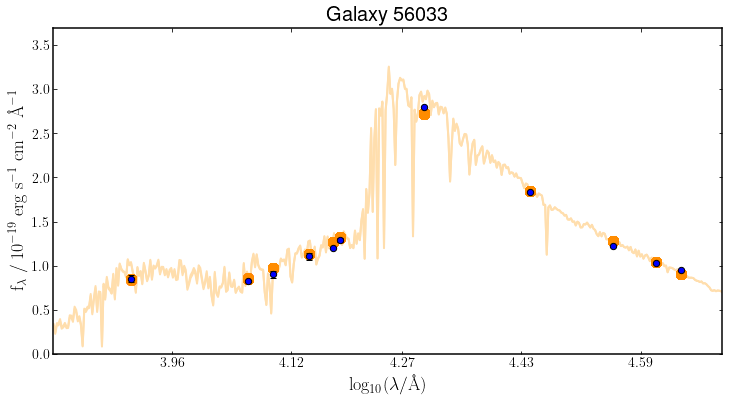

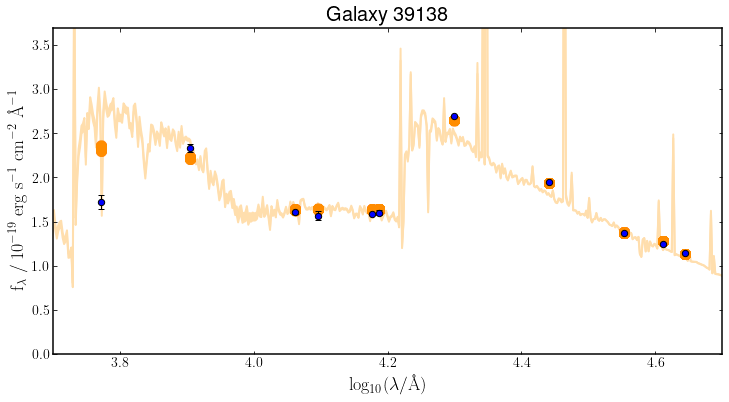

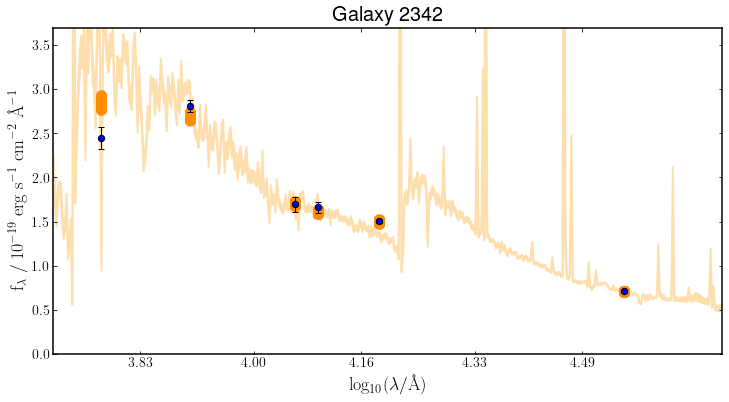

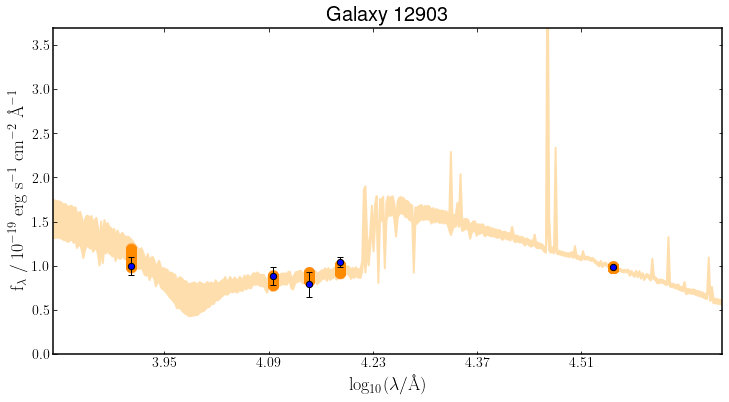

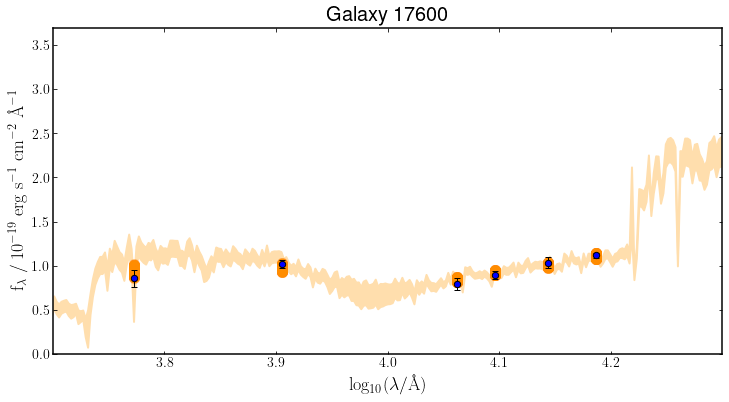

In [786]:
identifiers = ["56033", "39138", "2342", "12903", "17600", "19339", "29557", "30531", "36814", "42414", "46256", "48525", "49364", "54034", "55035", "55136", "55785", "56241"] 

for galaxy_id in tqdm(identifiers, desc='Fitting galaxies', unit='galaxy'):
    if galaxy_id == "39138":
        stat, fit = pipeline(galaxy_id, agn=True)
        galaxy_dictionary_final[galaxy_id] = stat
        fits_final.append(fit)
    else:
        stat, fit = pipeline(galaxy_id)
        galaxy_dictionary_final[galaxy_id] = stat
        fits_final.append(fit)

## Organize data

In [820]:
def get_mass_vs_sfr(galaxy_dictionary):
    """ Output of pipeline for number of galaxy objects with corresponding error, plus literature values
    """
    mass_2 = []
    sfr_2 = []
    age = []
    ssfr = []
    sfr_error_upper = []; sfr_error_lower = []
    mass_error_lower = []; mass_error_upper = []
    age_error_upper = []; age_error_lower = []
    ssfr_error_lower = []; ssfr_error_upper = []

    for item in list(galaxy_dictionary.values()): # ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]
        sfr_2.append(item[0])
        sfr_error_upper.append(abs(item[1]-item[0]))
        sfr_error_lower.append(abs(item[0]-item[2]))
        
        age.append(item[3])
        age_error_upper.append(abs(item[4]-item[3]))
        age_error_lower.append(abs(item[3]-item[5]))
        
        mass_2.append(item[6])
        mass_error_upper.append(abs(item[7]-item[6]))
        mass_error_lower.append(abs(item[6]-item[8]))

        ssfr.append(item[9])
        ssfr_error_upper.append(abs(item[10]-item[9]))
        ssfr_error_lower.append(abs(item[9]-item[11]))

    return mass_2, sfr_2, age, ssfr, mass_error_lower, mass_error_upper, sfr_error_lower, \
            sfr_error_upper, age_error_lower, age_error_upper, ssfr_error_lower, ssfr_error_upper

In [821]:
mass_2, sfr_2, age, ssfr, mass_error_lower, mass_error_upper, sfr_error_lower, \
sfr_error_upper, age_error_lower, age_error_upper, ssfr_error_lower, ssfr_error_upper = get_mass_vs_sfr(galaxy_dictionary_final)

In [822]:
df = pd.DataFrame()
df['ids'] = list(galaxy_dictionary_final.keys())
df['mass_2'] = mass_2
df['mass_error_lower'] = mass_error_lower
df['mass_error_upper'] = mass_error_upper
df['sfr_2'] = sfr_2
df['sfr_error_lower'] = sfr_error_lower
df['sfr_error_upper'] = sfr_error_upper

df['age'] = age
df['age_error_lower'] = age_error_lower
df['age_error_upper'] = age_error_upper
df['ssfr'] = ssfr
df['ssfr_error_lower'] = ssfr_error_lower
df['ssfr_error_upper'] = ssfr_error_upper

df['literature_masses'] = [10.82, 10.95, 10.55, 10.36, 10.9, 10.19, 9.59, 8.66, 9.66, 8.37, 10.41, 8.57, 9.57, 9.18, 8.62, 8.97, 10.07, 9.80]
df['lit_mass_error_lower'] = [0.02, 0.03, 0.15, 0.05, 0.10, 0.17, 0.21, 0.07, 0.10, 0.36, 0.06, 0.11, 0.13, 0.07, 0.08, 0.06, 0.13, 0.09]
df['lit_mass_error_upper'] = [0.02, 0.03, 0.16, 0.06, 0.09, 0.11, 0.17, 0.08, 0.10, 0.13, 0.05, 0.08, 0.07, 0.07, 0.09, 0.07, 0.09, 0.13]
df['literature_sfr'] = [1e-99, 1e-99, 131, 293, 15, 15, 6, 5, 28, 2, 213, 2, 25, 11, 4, 10, 19, 72]
df['lit_sfr_error_lower'] = [0, 0, 40, 38, 1, 2, 1, 1, 5, 1, 15, 1, 2, 1, 1, 1, 5, 14]
df['lit_sfr_error_upper'] = [0, 0, 84, 38, 4, 3, 1, 1, 5, 1, 26, 1, 3, 1, 1, 1, 16, 25]

In [1191]:
df

,ids,mass_2,mass_error_lower,mass_error_upper,sfr_2,sfr_error_lower,sfr_error_upper,age,age_error_lower,age_error_upper,ssfr,ssfr_error_lower,ssfr_error_upper,literature_masses,lit_mass_error_lower,lit_mass_error_upper,literature_sfr,lit_sfr_error_lower,lit_sfr_error_upper,sfr_percent_error
0,56033,10.819114,0.000194,0.000963,1.235555e-40,1.235555e-40,3.704047e-22,0.586500,0.000693,0.010893,-50.727252,11.628649,18.475784,10.82,0.02,0.02,1.000000e-99,0,0,1.235555e+61
1,39138,10.805803,0.010315,0.004084,1.210240e+02,4.618144e+00,3.847452e-01,0.380252,0.006445,0.007503,-8.722932,0.012715,0.001125,10.95,0.03,0.03,1.000000e-99,0,0,1.210240e+103
2,2342,10.355000,0.024616,0.027317,8.032374e+01,7.264551e+00,8.349357e+00,0.237011,0.040330,0.037653,-8.450156,0.063717,0.059010,10.55,0.15,0.16,1.310000e+02,40,84,3.868417e+01
3,12903,10.860755,0.073071,0.055816,1.156358e+02,5.978722e+01,4.997491e+00,0.491029,0.018970,0.451115,-8.797663,0.297498,0.018963,10.36,0.05,0.06,2.930000e+02,38,38,6.053387e+01
4,17600,11.250218,0.124236,0.074439,1.244810e+02,2.007912e+01,1.785070e+02,0.973505,0.535999,0.072820,-9.155115,0.098646,0.402474,10.90,0.10,0.09,1.500000e+01,1,4,7.298730e+02
5,19339,9.561577,0.044141,0.032824,2.326553e+01,7.372943e+00,1.829079e+00,0.111575,0.000640,0.066380,-8.194864,0.182071,0.001788,10.19,0.17,0.11,1.500000e+01,2,3,5.510357e+01
6,29557,9.568973,0.137614,0.123588,6.210317e+00,5.336662e-01,8.526750e-01,0.539649,0.211288,0.161567,-8.775859,0.138200,0.173698,9.59,0.21,0.17,6.000000e+00,1,1,3.505279e+00
7,30531,9.442050,0.006080,0.000671,1.439948e+01,3.138957e-01,8.353199e-02,0.132479,0.001962,0.002799,-8.283703,0.008055,0.006162,8.66,0.07,0.08,5.000000e+00,1,1,1.879895e+02
8,36814,9.778396,0.011769,0.004507,2.044117e+01,1.458493e-01,1.378921e+00,0.215632,0.025233,0.005318,-8.467891,0.000655,0.039422,9.66,0.10,0.10,2.800000e+01,5,5,2.699581e+01
9,42414,8.680401,0.003695,0.048948,3.110965e+00,5.065521e-01,7.712194e-02,0.102732,0.004595,0.047650,-8.187506,0.123761,0.011121,8.37,0.36,0.13,2.000000e+00,1,1,5.554824e+01


# Plot!

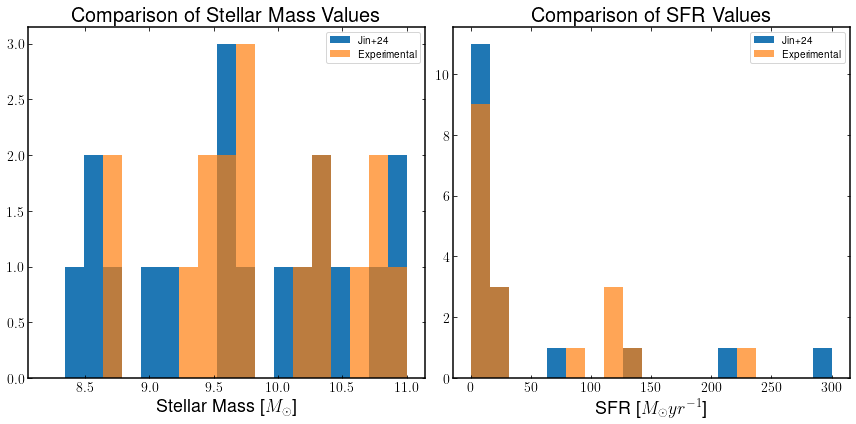

In [825]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bins=np.linspace(8.2, 11, 20)
bins1=np.linspace(0, 300, 20)

ax1.hist(df['literature_masses'], bins=bins, label='Jin+24')
ax1.hist(df['mass_2'], bins=bins, label='Experimental', alpha=0.7)
ax1.set_title('Comparison of Stellar Mass Values')
ax1.set_xlabel('Stellar Mass [$M_\odot$]')
ax1.legend()

ax2.hist(df['literature_sfr'], bins=bins1, label='Jin+24')
ax2.hist(df['sfr_2'], bins=bins1, label='Experimental', alpha=0.7)
ax2.set_title('Comparison of SFR Values')
ax2.set_xlabel('SFR [$M_\odot yr^{-1}$]')
ax2.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Comparison of Stellar Mass')

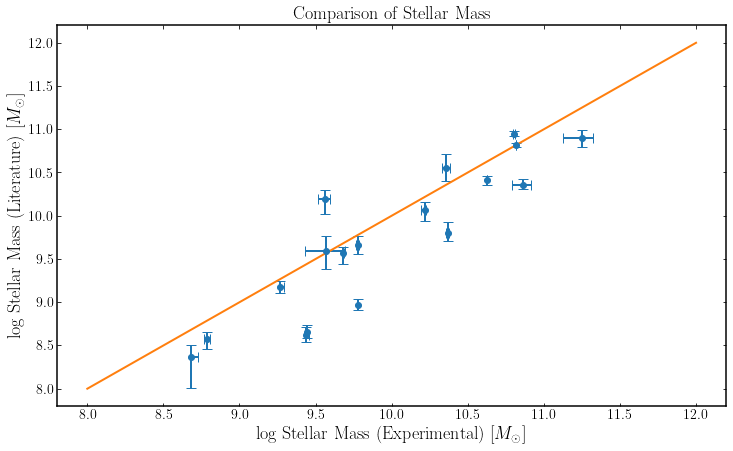

In [951]:
fig = plt.figure(figsize=(12, 7))
plt.errorbar(df['mass_2'], df['literature_masses'], xerr=[df['mass_error_lower'], df['mass_error_upper']], yerr=[df['lit_mass_error_lower'], df['lit_mass_error_upper']], fmt='o', capsize=5)
plt.plot(np.linspace(8, 12), np.linspace(8, 12))
plt.xlabel('log Stellar Mass (Experimental) [$M_\odot$]'); plt.ylabel('log Stellar Mass (Literature) [$M_\odot$]')
plt.title('Comparison of Stellar Mass', font='Computer Modern', fontsize=18)

Text(0.5, 1.0, 'Comparison of Star Formation Rates')

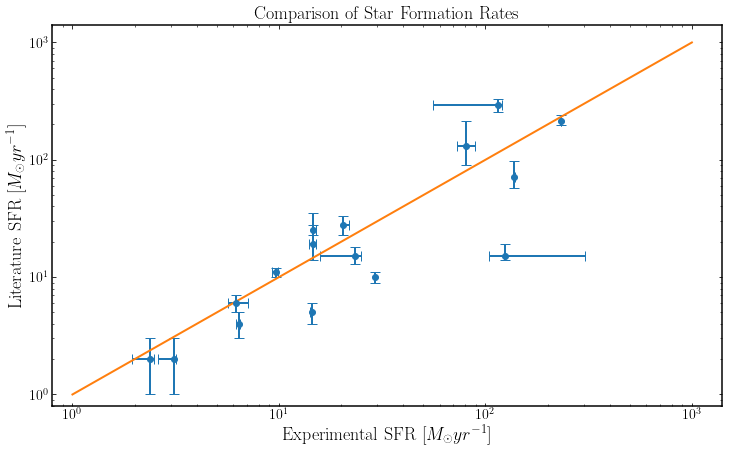

In [949]:
fig = plt.figure(figsize=(12, 7))
plt.errorbar(df['sfr_2'], df['literature_sfr'], xerr=[df['sfr_error_lower'], df['sfr_error_upper']], yerr=[df['lit_sfr_error_lower'], df['lit_sfr_error_upper']],fmt='o', capsize=5)
plt.plot(np.linspace(1, 1000), np.linspace(1, 1000))
plt.xscale('log'); plt.yscale('log')
plt.ylim(0.8, 1.4e3)
plt.xlim(0.8, 1.4e3)
plt.xlabel('Experimental SFR [$M_\odot yr^{-1}$]'); plt.ylabel('Literature SFR [$M_\odot yr^{-1}$]')
plt.title('Comparison of Star Formation Rates', font='Computer Modern', fontsize=18)

## SFMS (Schreiber+15)

In [1184]:
def get_SFR_line(mass):
    """ Mass in log scale
    """
    z=[]; SFR_line = []

    for fit in fits:
        red = fit.fit_instructions['redshift']
        z.append(red)

    m0 = 0.5; a0 = 1.5; a1 = 0.3; m1 = 0.36; a2 = 2.5 

    r = np.log10(1 + np.array(z))
    m = np.log10(np.array(10**mass/1e9))

    for i in range(len(r)):
        log10SFR = m[i] - m0 + (a0 * r[i]) - (a1*(max(0, m[i]-m1-a2*r[i])**2))*2
        SFR_line.append(log10SFR)
        
    mass_2 = np.array(mass)
    SFR_line = np.array(SFR_line)
    
    sorted_indices = np.argsort(mass_2)
    mass_2_sorted = mass_2[sorted_indices]
    SFR_line_sorted = SFR_line[sorted_indices]
    
    plt.scatter(mass_2, SFR_line)
    plt.plot(mass_2_sorted, SFR_line_sorted, 'r')

    return mass_2_sorted, SFR_line_sorted 

In [898]:
# getting the relative errors in log scale

log_sfr_2 = np.log10(df['sfr_2'])
log_sfr_2_lower = df['sfr_error_lower'] / df['sfr_2'] / np.log(10) 
log_sfr_2_upper = df['sfr_error_upper'] / df['sfr_2'] / np.log(10)

log_literature_sfr = np.log10(df['literature_sfr'])
log_lit_sfr_lower = df['lit_sfr_error_lower'] / df['literature_sfr'] / np.log(10)
log_lit_sfr_upper = df['lit_sfr_error_upper'] / df['literature_sfr'] / np.log(10)

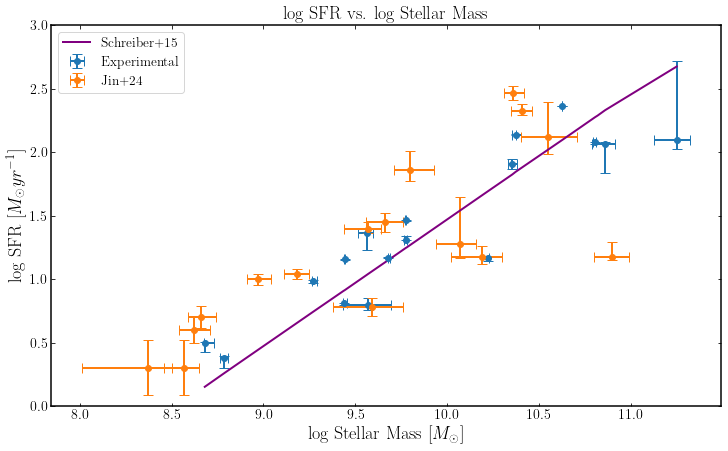

In [927]:
fig = plt.figure(figsize=(12, 7))

plt.errorbar(df['mass_2'][1:], np.log10(df['sfr_2'][1:]), xerr=[df['mass_error_lower'][1:], df['mass_error_upper'][1:]], yerr=[log_sfr_2_lower[1:], log_sfr_2_upper[1:]], fmt='o', capsize=5, label='Experimental')
plt.errorbar(df['literature_masses'], np.log10(df['literature_sfr']), xerr=[df['lit_mass_error_lower'], df['lit_mass_error_upper']], yerr=[log_lit_sfr_lower, log_lit_sfr_upper], fmt='o', capsize=5, label='Jin+24')

plt.ylim(0, 3)
plt.xlabel('log Stellar Mass [$M_\odot$]'); plt.ylabel('log SFR [$M_\odot yr^{-1}$]')

plt.plot(c, m, 'purple', label='Schreiber+15')
plt.title('log SFR vs. log Stellar Mass', font='Computer Modern', fontsize=18)

plt.legend(loc='upper left', fontsize=13.5)

# UVJ Diagram

In [831]:
def line(x):
    y = 0.88*x + 0.49
    return y

In [832]:
def uvj(fits):
    """ List of fits
    """
    UVs = []
    VJs = []
    
    for fit in fits:
        samples = list(fit.posterior.samples['chisq_phot'])
        best_value_index = samples.index(min(fit.posterior.samples['chisq_phot']))
        z = fit.fit_instructions['redshift']
        
        best_u, best_v, best_j = fit.posterior.samples['uvj'][best_value_index]
        UV = (best_u - best_v) #-2.5*np.log10(best_u/best_v)
        VJ = (best_v - best_j) 
        
        UVs.append(UV)
        VJs.append(VJ)
        
    return UVs, VJs

In [836]:
UV1, VJ1 = uvj(fits_final)

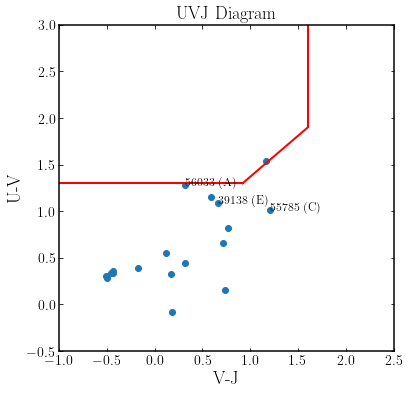

In [859]:
fig, ax = plt.subplots(figsize=(6, 6)) 

x1, x2 = -1, 2.5
y1, y2 = -0.5, 3
plt.xlim(x1, x2); plt.ylim(y1, y2)

ax.plot([x1,0.92],[1.3,1.3],'r',lw=2) # left
x = np.linspace(0.92, 1.6, 100)
ax.plot(x, line(x), 'r')
ax.plot([1.6,1.6],[1.9,y2],'r',lw=2) # top

plt.xlabel('V-J'); plt.ylabel('U-V')
plt.title('UVJ Diagram', font='Computer Modern', fontsize=18)

plt.scatter(VJ1, UV1)

for i in range(len(df['ids'])):
    if df['ids'][i] == '56033':
        plt.text(VJ1[i], UV1[i], str(int(df['ids'][i]))+" (A)", fontsize=12, ha='left')
    if df['ids'][i] == '39138':
        plt.text(VJ1[i], UV1[i], str(int(df['ids'][i]))+" (E)", fontsize=12, ha='left')
    if df['ids'][i] == '55785':
        plt.text(VJ1[i], UV1[i], str(int(df['ids'][i]))+" (C)", fontsize=12, ha='left')